In [1]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import trange, tqdm

import torch
from torchvision import transforms

from adabound import AdaBound
from pytorchUtils import Pipeline, ResNet18MNIST
from retinal_implants_utils import MNISTpulse2percept

<ipython-input-1-ebfef1f0950f>:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange, tqdm


In [2]:
%matplotlib inline

In [3]:
DATA_PATH              = os.path.join(os.path.dirname(os.getcwd()), 'simulate MNIST - create new datasets', 'data')
# DATA_PATH              = os.path.join(os.getcwd(), 'retinal_implants_utils', 'data')
FULL_ARGUSII_DATA_PATH = os.path.join(DATA_PATH, 'MNIST', 'processed')
MNIST_SUBSET_DATA_PATH = os.path.join(DATA_PATH, 'MNIST_2000_400', 'processed')

In [4]:
def get_dataset_mean_std(path, print_results=True):
    # get mean and std for the train data in order to normalize our data later
    trainset      = MNISTpulse2percept(path=path, transform=transforms.ToTensor())
    trainloader   = torch.utils.data.DataLoader(trainset, batch_size=len(trainset), shuffle=False)
    trainset_mean = next(iter(trainloader))[0].mean(axis=(0, 2, 3))[0]
    trainset_std  = next(iter(trainloader))[0].std( axis=(0, 2, 3))[0]
    if print_results:
        print(f' Trainset mean value for each channel is: {trainset_mean:.2f}')
        print(f' Trainset std  value for each channel is: {trainset_std :.2f}')

    return trainset_mean, trainset_std

In [5]:
def get_dataset_loaders(path):
    mean, std = get_dataset_mean_std(path)
    transform   = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.ToTensor(),
                                      transforms.Lambda(lambda x: x.repeat(3, 1, 1)), #grayscale to RGB
                                      transforms.Normalize(mean, std)])

    trainset = MNISTpulse2percept(path=path, train=True,  transform=transform)
    testset  = MNISTpulse2percept(path=path, train=False, transform=transform)

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
    testloader  = torch.utils.data.DataLoader(testset,  batch_size=64, shuffle=True)

    return trainloader, testloader

# CUSTOM IMPLANTS' EVALUATION - MNIST SUBSET DATA PATH

In [7]:
e_num_sides = [  5,   8,  10, 15, 20, 25]
e_radius_lb = [ 10,  10,  10, 10, 10, 10]
e_radius_ub = [400, 400, 400, 90, 90, 60]
spacing     = None
total_area  = 4000

# e_num_sides = [25]
# e_radius_lb = [10]
# e_radius_ub = [60]

e_num_sides_acc  = np.zeros((len(e_num_sides), (max(e_radius_ub) - min(e_radius_lb))//10 + 1, 2))
e_radius_acc     = np.zeros(((max(e_radius_ub) - min(e_radius_lb))//10 + 1, len(e_num_sides), 2))

e_num_sides_loss = np.zeros_like(e_num_sides_acc)
e_radius_loss    = np.zeros_like(e_radius_acc)

e_num_sides_acc_init  = np.zeros_like(e_num_sides_acc)
e_radius_acc_init     = np.zeros_like(e_radius_acc)

e_num_sides_loss_init = np.zeros_like(e_num_sides_acc)
e_radius_loss_init    = np.zeros_like(e_radius_acc)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [27]:
#         print('# ------------------ AXON MAP MODEL ----------------- #')
#         model = ResNet18MNIST(pretrained=True,
#                               feature_extraction=True,
#                               load_state_path='./data/MNIST__ResNet18Model__Adabound__25_epochs.pth')

#         criterion = torch.nn.CrossEntropyLoss()
#         optimizer = AdaBound(model.parameters(), lr=1e-3, final_lr=0.1)

#         trainloader, testloader = get_dataset_loaders(os.path.join(MNIST_SUBSET_DATA_PATH,
#                                                                    'AxonMapModel-'+implant_name))
#         ppln_axon = Pipeline(model, device, optimizer, criterion,
#                              trainloader, testloader, testloader,
#                              live_plot=False)

#         axon_init_loss, axon_init_accu = ppln_axon.test()
#         _ = ppln_axon.training(epochs=1)
#         axon_loss, axon_accu = ppln_axon.test(ppln_axon.best_model)
#         torch.save(ppln_axon.best_model.state_dict(),
#            os.path.join(os.getcwd(), 'data',
#                         f'MNIST_2000_400_{implant_name}_AxonMapModel__ResNet18Model__Adabound__1_epoch.pth'))

#         # ---------------- SCORE BOARD MODEL ---------------- #
#         print('# ---------------- SCORE BOARD MODEL ---------------- #')
#         model = ResNet18MNIST(pretrained=True,
#                               feature_extraction=True,
#                               load_state_path='./data/MNIST__ResNet18Model__Adabound__25_epochs.pth')

#         criterion = torch.nn.CrossEntropyLoss()
#         optimizer = AdaBound(model.parameters(), lr=1e-3, final_lr=0.1)

#         trainloader, testloader = get_dataset_loaders(os.path.join(MNIST_SUBSET_DATA_PATH,
#                                                                    'ScoreboardModel-'+implant_name))
#         ppln_sboard = Pipeline(model, device, optimizer, criterion,
#                                trainloader, testloader, testloader,
#                                live_plot=False)

#         sboard_init_loss, sboard_init_accu = ppln_sboard.test()
#         _ = ppln_sboard.training(epochs=1)
#         sboard_loss, sboard_accu = ppln_sboard.test(ppln_sboard.best_model)
#         torch.save(ppln_sboard.best_model.state_dict(),
#            os.path.join(os.getcwd(), 'data',
#                         f'MNIST_2000_400_{implant_name}_ScoreBoardModel__ResNet18Model__Adabound__1_epoch.pth'))

def one(model_name, implant_name, load_state_path, overwrite=False):
    print(f'# ------------------ {model_name} ----------------- #')
    out_path = os.path.join(os.getcwd(), 'evaluation', 'data', 'models',
                            f'MNIST_2000_400_{implant_name}_{model_name}__ResNet18Model__Adabound__1_epoch.pth')
    model = ResNet18MNIST(pretrained=True,
                          feature_extraction=True,
                          load_state_path=load_state_path)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = AdaBound(model.parameters(), lr=1e-3, final_lr=0.1)
#     print(os.path.join(MNIST_SUBSET_DATA_PATH, model_name+'-'+implant_name))
#     print(os.listdir(os.path.join(MNIST_SUBSET_DATA_PATH, model_name+'-'+implant_name)))
    trainloader, testloader = get_dataset_loaders(os.path.join(MNIST_SUBSET_DATA_PATH,
                                                               model_name+'-'+implant_name))
    ppln = Pipeline(model, device, optimizer, criterion,
                    trainloader, testloader, testloader,
                    live_plot=False)

    init_loss, init_accu = ppln.test()

    if overwrite or not os.path.exists(out_path):
        _ = ppln.training(epochs=1)
        loss, accu = ppln.test(ppln.best_model)
        torch.save(ppln.best_model.state_dict(), out_path)
    else:
        print(f'{implant_name} is already trained for {model_name}')
        ppln.model.load_state(out_path)
        loss, accu = ppln.test(ppln.model)

    return init_loss, init_accu, loss, accu, ppln.model

In [28]:
pbar = tqdm(total=sum(1+(np.array(e_radius_ub)-np.array(e_radius_lb))//10))

for ens_idx, e_num_side in enumerate(e_num_sides):
    print("e_num_side", e_num_side)
    for er_idx, e_radius in enumerate(range(e_radius_lb[ens_idx], e_radius_ub[ens_idx] + 1, 10)):
        print("e_radius", e_radius)
        implant_name = 'e_num_side='+str(e_num_side)+'-e_radius='+str(e_radius)+ \
                       '-spacing='+str(spacing)+'-total_area='+str(total_area)

        # ------------------ AXON MAP MODEL ----------------- #
        (axon_init_loss,   axon_init_accu,
         axon_loss,   axon_accu,   _) = one('AxonMapModel',    implant_name,
                                           './data/MNIST__ResNet18Model__Adabound__25_epochs.pth')
        # ---------------- SCORE BOARD MODEL ---------------- #
        (sboard_init_loss, sboard_init_accu,
         sboard_loss, sboard_accu, _) = one('ScoreboardModel', implant_name,
                                           './data/MNIST__ResNet18Model__Adabound__25_epochs.pth')

        # ----------------- FILL THE ARRAYS ----------------- #
        e_num_sides_acc[ens_idx, er_idx, :]  =[axon_accu, sboard_accu]
        e_radius_acc[er_idx, ens_idx, :]     =[axon_accu, sboard_accu]

        e_num_sides_loss[ens_idx, er_idx, :] =[axon_loss, sboard_loss]
        e_radius_loss[er_idx, ens_idx, :]    =[axon_loss, sboard_loss]

        e_num_sides_acc_init[ens_idx, er_idx, :]  =[axon_init_accu, sboard_init_accu]
        e_radius_acc_init[er_idx, ens_idx, :]     =[axon_init_accu, sboard_init_accu]

        e_num_sides_loss_init[ens_idx, er_idx, :] =[axon_init_loss, sboard_init_loss]
        e_radius_loss_init[er_idx, ens_idx, :]    =[axon_init_loss, sboard_init_loss]

        pbar.update()
pbar.close()

e_num_side 5
e_radius 10
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.08
 Trainset std  value for each channel is: 0.15



e_num_side=5-e_radius=10-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.05
 Trainset std  value for each channel is: 0.13



e_num_side=5-e_radius=10-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 20
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.08
 Trainset std  value for each channel is: 0.15



e_num_side=5-e_radius=20-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.05
 Trainset std  value for each channel is: 0.13



e_num_side=5-e_radius=20-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 30
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.08
 Trainset std  value for each channel is: 0.15



e_num_side=5-e_radius=30-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.05
 Trainset std  value for each channel is: 0.13



e_num_side=5-e_radius=30-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 40
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.08
 Trainset std  value for each channel is: 0.15



e_num_side=5-e_radius=40-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.05
 Trainset std  value for each channel is: 0.13



e_num_side=5-e_radius=40-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 50
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.08
 Trainset std  value for each channel is: 0.15



e_num_side=5-e_radius=50-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.05
 Trainset std  value for each channel is: 0.13



e_num_side=5-e_radius=50-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 60
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.08
 Trainset std  value for each channel is: 0.15



e_num_side=5-e_radius=60-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.05
 Trainset std  value for each channel is: 0.13



e_num_side=5-e_radius=60-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 70
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.08
 Trainset std  value for each channel is: 0.15



e_num_side=5-e_radius=70-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.05
 Trainset std  value for each channel is: 0.13



e_num_side=5-e_radius=70-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 80
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.08
 Trainset std  value for each channel is: 0.15



e_num_side=5-e_radius=80-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.05
 Trainset std  value for each channel is: 0.13



e_num_side=5-e_radius=80-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 90
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.08
 Trainset std  value for each channel is: 0.15



e_num_side=5-e_radius=90-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.05
 Trainset std  value for each channel is: 0.13



e_num_side=5-e_radius=90-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 100
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.08
 Trainset std  value for each channel is: 0.15



e_num_side=5-e_radius=100-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.05
 Trainset std  value for each channel is: 0.13



e_num_side=5-e_radius=100-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 110
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.08
 Trainset std  value for each channel is: 0.15



e_num_side=5-e_radius=110-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.05
 Trainset std  value for each channel is: 0.13



e_num_side=5-e_radius=110-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 120
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.08
 Trainset std  value for each channel is: 0.15



e_num_side=5-e_radius=120-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.05
 Trainset std  value for each channel is: 0.13



e_num_side=5-e_radius=120-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 130
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.08
 Trainset std  value for each channel is: 0.15



e_num_side=5-e_radius=130-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.05
 Trainset std  value for each channel is: 0.13



e_num_side=5-e_radius=130-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 140
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.08
 Trainset std  value for each channel is: 0.15



e_num_side=5-e_radius=140-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.05
 Trainset std  value for each channel is: 0.13



e_num_side=5-e_radius=140-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 150
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.08
 Trainset std  value for each channel is: 0.15



e_num_side=5-e_radius=150-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.05
 Trainset std  value for each channel is: 0.13



e_num_side=5-e_radius=150-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 160
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.08
 Trainset std  value for each channel is: 0.15



e_num_side=5-e_radius=160-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.05
 Trainset std  value for each channel is: 0.13



e_num_side=5-e_radius=160-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 170
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.08
 Trainset std  value for each channel is: 0.15



e_num_side=5-e_radius=170-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.05
 Trainset std  value for each channel is: 0.13



e_num_side=5-e_radius=170-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 180
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.08
 Trainset std  value for each channel is: 0.15



e_num_side=5-e_radius=180-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.05
 Trainset std  value for each channel is: 0.13



e_num_side=5-e_radius=180-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 190
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.08
 Trainset std  value for each channel is: 0.15



e_num_side=5-e_radius=190-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.05
 Trainset std  value for each channel is: 0.13



e_num_side=5-e_radius=190-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 200
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.08
 Trainset std  value for each channel is: 0.15



e_num_side=5-e_radius=200-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.05
 Trainset std  value for each channel is: 0.13



e_num_side=5-e_radius=200-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 210
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.08
 Trainset std  value for each channel is: 0.15



e_num_side=5-e_radius=210-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.05
 Trainset std  value for each channel is: 0.13



e_num_side=5-e_radius=210-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 220
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.08
 Trainset std  value for each channel is: 0.15



e_num_side=5-e_radius=220-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.05
 Trainset std  value for each channel is: 0.13



e_num_side=5-e_radius=220-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 230
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.08
 Trainset std  value for each channel is: 0.15



e_num_side=5-e_radius=230-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.05
 Trainset std  value for each channel is: 0.13



e_num_side=5-e_radius=230-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 240
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.08
 Trainset std  value for each channel is: 0.15



e_num_side=5-e_radius=240-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.05
 Trainset std  value for each channel is: 0.13



e_num_side=5-e_radius=240-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 250
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.08
 Trainset std  value for each channel is: 0.15



e_num_side=5-e_radius=250-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.05
 Trainset std  value for each channel is: 0.13



e_num_side=5-e_radius=250-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 260
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.08
 Trainset std  value for each channel is: 0.15



e_num_side=5-e_radius=260-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.05
 Trainset std  value for each channel is: 0.13



e_num_side=5-e_radius=260-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 270
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.08
 Trainset std  value for each channel is: 0.15



e_num_side=5-e_radius=270-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.05
 Trainset std  value for each channel is: 0.13



e_num_side=5-e_radius=270-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 280
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.08
 Trainset std  value for each channel is: 0.15



e_num_side=5-e_radius=280-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.05
 Trainset std  value for each channel is: 0.13



e_num_side=5-e_radius=280-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 290
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.08
 Trainset std  value for each channel is: 0.15



e_num_side=5-e_radius=290-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.05
 Trainset std  value for each channel is: 0.13



e_num_side=5-e_radius=290-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 300
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.08
 Trainset std  value for each channel is: 0.15



e_num_side=5-e_radius=300-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.05
 Trainset std  value for each channel is: 0.13



e_num_side=5-e_radius=300-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 310
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.08
 Trainset std  value for each channel is: 0.15



e_num_side=5-e_radius=310-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.05
 Trainset std  value for each channel is: 0.13



e_num_side=5-e_radius=310-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 320
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.08
 Trainset std  value for each channel is: 0.15



e_num_side=5-e_radius=320-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.05
 Trainset std  value for each channel is: 0.13



e_num_side=5-e_radius=320-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 330
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.08
 Trainset std  value for each channel is: 0.15



e_num_side=5-e_radius=330-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.05
 Trainset std  value for each channel is: 0.13



e_num_side=5-e_radius=330-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 340
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.08
 Trainset std  value for each channel is: 0.15



e_num_side=5-e_radius=340-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.05
 Trainset std  value for each channel is: 0.13



e_num_side=5-e_radius=340-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 350
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.08
 Trainset std  value for each channel is: 0.15



e_num_side=5-e_radius=350-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.05
 Trainset std  value for each channel is: 0.13



e_num_side=5-e_radius=350-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 360
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.08
 Trainset std  value for each channel is: 0.15



e_num_side=5-e_radius=360-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.05
 Trainset std  value for each channel is: 0.13



e_num_side=5-e_radius=360-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 370
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.08
 Trainset std  value for each channel is: 0.15



e_num_side=5-e_radius=370-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.05
 Trainset std  value for each channel is: 0.13



e_num_side=5-e_radius=370-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 380
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.08
 Trainset std  value for each channel is: 0.15



e_num_side=5-e_radius=380-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.05
 Trainset std  value for each channel is: 0.13



e_num_side=5-e_radius=380-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 390
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.08
 Trainset std  value for each channel is: 0.15



e_num_side=5-e_radius=390-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.05
 Trainset std  value for each channel is: 0.13



e_num_side=5-e_radius=390-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 400
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.08
 Trainset std  value for each channel is: 0.15



e_num_side=5-e_radius=400-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.05
 Trainset std  value for each channel is: 0.13



e_num_side=5-e_radius=400-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_num_side 8
e_radius 10
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.15
 Trainset std  value for each channel is: 0.20



e_num_side=8-e_radius=10-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.10
 Trainset std  value for each channel is: 0.17



e_num_side=8-e_radius=10-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 20
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.15
 Trainset std  value for each channel is: 0.20



e_num_side=8-e_radius=20-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.10
 Trainset std  value for each channel is: 0.17



e_num_side=8-e_radius=20-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 30
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.15
 Trainset std  value for each channel is: 0.20



e_num_side=8-e_radius=30-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.10
 Trainset std  value for each channel is: 0.17



e_num_side=8-e_radius=30-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 40
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.15
 Trainset std  value for each channel is: 0.20



e_num_side=8-e_radius=40-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.10
 Trainset std  value for each channel is: 0.17



e_num_side=8-e_radius=40-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 50
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.15
 Trainset std  value for each channel is: 0.20



e_num_side=8-e_radius=50-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.10
 Trainset std  value for each channel is: 0.17



e_num_side=8-e_radius=50-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 60
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.15
 Trainset std  value for each channel is: 0.20



e_num_side=8-e_radius=60-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.10
 Trainset std  value for each channel is: 0.17



e_num_side=8-e_radius=60-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 70
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.15
 Trainset std  value for each channel is: 0.20



e_num_side=8-e_radius=70-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.10
 Trainset std  value for each channel is: 0.17



e_num_side=8-e_radius=70-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 80
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.15
 Trainset std  value for each channel is: 0.20



e_num_side=8-e_radius=80-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.10
 Trainset std  value for each channel is: 0.17



e_num_side=8-e_radius=80-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 90
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.15
 Trainset std  value for each channel is: 0.20



e_num_side=8-e_radius=90-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.10
 Trainset std  value for each channel is: 0.17



e_num_side=8-e_radius=90-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 100
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.15
 Trainset std  value for each channel is: 0.20



e_num_side=8-e_radius=100-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.10
 Trainset std  value for each channel is: 0.17



e_num_side=8-e_radius=100-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 110
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.15
 Trainset std  value for each channel is: 0.20



e_num_side=8-e_radius=110-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.10
 Trainset std  value for each channel is: 0.17



e_num_side=8-e_radius=110-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 120
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.15
 Trainset std  value for each channel is: 0.20



e_num_side=8-e_radius=120-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.10
 Trainset std  value for each channel is: 0.17



e_num_side=8-e_radius=120-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 130
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.15
 Trainset std  value for each channel is: 0.20



e_num_side=8-e_radius=130-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.10
 Trainset std  value for each channel is: 0.17



e_num_side=8-e_radius=130-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 140
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.15
 Trainset std  value for each channel is: 0.20



e_num_side=8-e_radius=140-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.10
 Trainset std  value for each channel is: 0.17



e_num_side=8-e_radius=140-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 150
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.15
 Trainset std  value for each channel is: 0.20



e_num_side=8-e_radius=150-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.10
 Trainset std  value for each channel is: 0.17



e_num_side=8-e_radius=150-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 160
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.15
 Trainset std  value for each channel is: 0.20



e_num_side=8-e_radius=160-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.10
 Trainset std  value for each channel is: 0.17



e_num_side=8-e_radius=160-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 170
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.15
 Trainset std  value for each channel is: 0.20



e_num_side=8-e_radius=170-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.10
 Trainset std  value for each channel is: 0.17



e_num_side=8-e_radius=170-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 180
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.15
 Trainset std  value for each channel is: 0.20



e_num_side=8-e_radius=180-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.10
 Trainset std  value for each channel is: 0.17



e_num_side=8-e_radius=180-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 190
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.15
 Trainset std  value for each channel is: 0.20



e_num_side=8-e_radius=190-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.10
 Trainset std  value for each channel is: 0.17



e_num_side=8-e_radius=190-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 200
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.15
 Trainset std  value for each channel is: 0.20



e_num_side=8-e_radius=200-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.10
 Trainset std  value for each channel is: 0.17



e_num_side=8-e_radius=200-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 210
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.15
 Trainset std  value for each channel is: 0.20



e_num_side=8-e_radius=210-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.10
 Trainset std  value for each channel is: 0.17



e_num_side=8-e_radius=210-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 220
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.15
 Trainset std  value for each channel is: 0.20



e_num_side=8-e_radius=220-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.10
 Trainset std  value for each channel is: 0.17



e_num_side=8-e_radius=220-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 230
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.15
 Trainset std  value for each channel is: 0.20



e_num_side=8-e_radius=230-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.10
 Trainset std  value for each channel is: 0.17



e_num_side=8-e_radius=230-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 240
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.15
 Trainset std  value for each channel is: 0.20



e_num_side=8-e_radius=240-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.10
 Trainset std  value for each channel is: 0.17



e_num_side=8-e_radius=240-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 250
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.15
 Trainset std  value for each channel is: 0.20



e_num_side=8-e_radius=250-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.10
 Trainset std  value for each channel is: 0.17



e_num_side=8-e_radius=250-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 260
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.15
 Trainset std  value for each channel is: 0.20



e_num_side=8-e_radius=260-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.10
 Trainset std  value for each channel is: 0.17



e_num_side=8-e_radius=260-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 270
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.15
 Trainset std  value for each channel is: 0.20



e_num_side=8-e_radius=270-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.10
 Trainset std  value for each channel is: 0.17



e_num_side=8-e_radius=270-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 280
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.15
 Trainset std  value for each channel is: 0.20



e_num_side=8-e_radius=280-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.10
 Trainset std  value for each channel is: 0.17



e_num_side=8-e_radius=280-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 290
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.15
 Trainset std  value for each channel is: 0.20



e_num_side=8-e_radius=290-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.10
 Trainset std  value for each channel is: 0.17



e_num_side=8-e_radius=290-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 300
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.15
 Trainset std  value for each channel is: 0.20



e_num_side=8-e_radius=300-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.10
 Trainset std  value for each channel is: 0.17



e_num_side=8-e_radius=300-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 310
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.15
 Trainset std  value for each channel is: 0.20



e_num_side=8-e_radius=310-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.10
 Trainset std  value for each channel is: 0.17



e_num_side=8-e_radius=310-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 320
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.15
 Trainset std  value for each channel is: 0.20



e_num_side=8-e_radius=320-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.10
 Trainset std  value for each channel is: 0.17



e_num_side=8-e_radius=320-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 330
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.15
 Trainset std  value for each channel is: 0.20



e_num_side=8-e_radius=330-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.10
 Trainset std  value for each channel is: 0.17



e_num_side=8-e_radius=330-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 340
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.15
 Trainset std  value for each channel is: 0.20



e_num_side=8-e_radius=340-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.10
 Trainset std  value for each channel is: 0.17



e_num_side=8-e_radius=340-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 350
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.15
 Trainset std  value for each channel is: 0.20



e_num_side=8-e_radius=350-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.10
 Trainset std  value for each channel is: 0.17



e_num_side=8-e_radius=350-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 360
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.15
 Trainset std  value for each channel is: 0.20



e_num_side=8-e_radius=360-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.10
 Trainset std  value for each channel is: 0.17



e_num_side=8-e_radius=360-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 370
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.15
 Trainset std  value for each channel is: 0.20



e_num_side=8-e_radius=370-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.10
 Trainset std  value for each channel is: 0.17



e_num_side=8-e_radius=370-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 380
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.15
 Trainset std  value for each channel is: 0.20



e_num_side=8-e_radius=380-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.10
 Trainset std  value for each channel is: 0.17



e_num_side=8-e_radius=380-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 390
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.15
 Trainset std  value for each channel is: 0.20



e_num_side=8-e_radius=390-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.10
 Trainset std  value for each channel is: 0.17



e_num_side=8-e_radius=390-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 400
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.15
 Trainset std  value for each channel is: 0.20



e_num_side=8-e_radius=400-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.10
 Trainset std  value for each channel is: 0.17



e_num_side=8-e_radius=400-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_num_side 10
e_radius 10
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.19
 Trainset std  value for each channel is: 0.23



e_num_side=10-e_radius=10-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.14
 Trainset std  value for each channel is: 0.20



e_num_side=10-e_radius=10-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 20
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.19
 Trainset std  value for each channel is: 0.23



e_num_side=10-e_radius=20-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.14
 Trainset std  value for each channel is: 0.20



e_num_side=10-e_radius=20-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 30
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.19
 Trainset std  value for each channel is: 0.23



e_num_side=10-e_radius=30-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.14
 Trainset std  value for each channel is: 0.20



e_num_side=10-e_radius=30-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 40
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.19
 Trainset std  value for each channel is: 0.23



e_num_side=10-e_radius=40-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.14
 Trainset std  value for each channel is: 0.20



e_num_side=10-e_radius=40-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 50
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.19
 Trainset std  value for each channel is: 0.23



e_num_side=10-e_radius=50-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.14
 Trainset std  value for each channel is: 0.20



e_num_side=10-e_radius=50-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 60
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.19
 Trainset std  value for each channel is: 0.23



e_num_side=10-e_radius=60-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.14
 Trainset std  value for each channel is: 0.20



e_num_side=10-e_radius=60-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 70
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.19
 Trainset std  value for each channel is: 0.23



e_num_side=10-e_radius=70-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.14
 Trainset std  value for each channel is: 0.20



e_num_side=10-e_radius=70-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 80
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.19
 Trainset std  value for each channel is: 0.23



e_num_side=10-e_radius=80-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.14
 Trainset std  value for each channel is: 0.20



e_num_side=10-e_radius=80-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 90
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.19
 Trainset std  value for each channel is: 0.23



e_num_side=10-e_radius=90-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.14
 Trainset std  value for each channel is: 0.20



e_num_side=10-e_radius=90-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 100
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.19
 Trainset std  value for each channel is: 0.23



e_num_side=10-e_radius=100-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.14
 Trainset std  value for each channel is: 0.20



e_num_side=10-e_radius=100-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 110
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.19
 Trainset std  value for each channel is: 0.23



e_num_side=10-e_radius=110-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.14
 Trainset std  value for each channel is: 0.20



e_num_side=10-e_radius=110-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 120
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.19
 Trainset std  value for each channel is: 0.23



e_num_side=10-e_radius=120-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.14
 Trainset std  value for each channel is: 0.20



e_num_side=10-e_radius=120-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 130
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.19
 Trainset std  value for each channel is: 0.23



e_num_side=10-e_radius=130-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.14
 Trainset std  value for each channel is: 0.20



e_num_side=10-e_radius=130-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 140
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.19
 Trainset std  value for each channel is: 0.23



e_num_side=10-e_radius=140-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.14
 Trainset std  value for each channel is: 0.20



e_num_side=10-e_radius=140-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 150
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.19
 Trainset std  value for each channel is: 0.23



e_num_side=10-e_radius=150-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.14
 Trainset std  value for each channel is: 0.20



e_num_side=10-e_radius=150-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 160
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.19
 Trainset std  value for each channel is: 0.23



e_num_side=10-e_radius=160-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.14
 Trainset std  value for each channel is: 0.20



e_num_side=10-e_radius=160-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 170
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.19
 Trainset std  value for each channel is: 0.23



e_num_side=10-e_radius=170-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.14
 Trainset std  value for each channel is: 0.20



e_num_side=10-e_radius=170-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 180
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.19
 Trainset std  value for each channel is: 0.23



e_num_side=10-e_radius=180-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.14
 Trainset std  value for each channel is: 0.20



e_num_side=10-e_radius=180-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 190
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.19
 Trainset std  value for each channel is: 0.23



e_num_side=10-e_radius=190-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.14
 Trainset std  value for each channel is: 0.20



e_num_side=10-e_radius=190-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 200
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.19
 Trainset std  value for each channel is: 0.23



e_num_side=10-e_radius=200-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.14
 Trainset std  value for each channel is: 0.20



e_num_side=10-e_radius=200-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 210
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.19
 Trainset std  value for each channel is: 0.23



e_num_side=10-e_radius=210-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.14
 Trainset std  value for each channel is: 0.20



e_num_side=10-e_radius=210-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 220
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.19
 Trainset std  value for each channel is: 0.23



e_num_side=10-e_radius=220-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.14
 Trainset std  value for each channel is: 0.20



e_num_side=10-e_radius=220-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 230
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.19
 Trainset std  value for each channel is: 0.23



e_num_side=10-e_radius=230-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.14
 Trainset std  value for each channel is: 0.20



e_num_side=10-e_radius=230-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 240
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.19
 Trainset std  value for each channel is: 0.23



e_num_side=10-e_radius=240-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.14
 Trainset std  value for each channel is: 0.20



e_num_side=10-e_radius=240-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 250
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.19
 Trainset std  value for each channel is: 0.23



e_num_side=10-e_radius=250-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.14
 Trainset std  value for each channel is: 0.20



e_num_side=10-e_radius=250-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 260
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.19
 Trainset std  value for each channel is: 0.23



e_num_side=10-e_radius=260-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.14
 Trainset std  value for each channel is: 0.20



e_num_side=10-e_radius=260-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 270
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.19
 Trainset std  value for each channel is: 0.23



e_num_side=10-e_radius=270-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.14
 Trainset std  value for each channel is: 0.20



e_num_side=10-e_radius=270-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 280
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.19
 Trainset std  value for each channel is: 0.23



e_num_side=10-e_radius=280-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.14
 Trainset std  value for each channel is: 0.20



e_num_side=10-e_radius=280-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 290
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.19
 Trainset std  value for each channel is: 0.23



e_num_side=10-e_radius=290-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.14
 Trainset std  value for each channel is: 0.20



e_num_side=10-e_radius=290-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 300
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.19
 Trainset std  value for each channel is: 0.23



e_num_side=10-e_radius=300-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.14
 Trainset std  value for each channel is: 0.20



e_num_side=10-e_radius=300-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 310
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.19
 Trainset std  value for each channel is: 0.23



e_num_side=10-e_radius=310-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.14
 Trainset std  value for each channel is: 0.20



e_num_side=10-e_radius=310-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 320
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.19
 Trainset std  value for each channel is: 0.23



e_num_side=10-e_radius=320-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.14
 Trainset std  value for each channel is: 0.20



e_num_side=10-e_radius=320-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 330
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.19
 Trainset std  value for each channel is: 0.23



e_num_side=10-e_radius=330-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.14
 Trainset std  value for each channel is: 0.20



e_num_side=10-e_radius=330-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 340
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.19
 Trainset std  value for each channel is: 0.23



e_num_side=10-e_radius=340-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.14
 Trainset std  value for each channel is: 0.20



e_num_side=10-e_radius=340-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 350
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.19
 Trainset std  value for each channel is: 0.23



e_num_side=10-e_radius=350-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.14
 Trainset std  value for each channel is: 0.20



e_num_side=10-e_radius=350-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 360
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.19
 Trainset std  value for each channel is: 0.23



e_num_side=10-e_radius=360-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.14
 Trainset std  value for each channel is: 0.20



e_num_side=10-e_radius=360-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 370
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.19
 Trainset std  value for each channel is: 0.23



e_num_side=10-e_radius=370-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.14
 Trainset std  value for each channel is: 0.20



e_num_side=10-e_radius=370-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 380
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.19
 Trainset std  value for each channel is: 0.23



e_num_side=10-e_radius=380-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.14
 Trainset std  value for each channel is: 0.20



e_num_side=10-e_radius=380-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 390
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.19
 Trainset std  value for each channel is: 0.23



e_num_side=10-e_radius=390-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.14
 Trainset std  value for each channel is: 0.20



e_num_side=10-e_radius=390-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 400
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.19
 Trainset std  value for each channel is: 0.23



e_num_side=10-e_radius=400-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.14
 Trainset std  value for each channel is: 0.20



e_num_side=10-e_radius=400-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_num_side 15
e_radius 10
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.27
 Trainset std  value for each channel is: 0.31



e_num_side=15-e_radius=10-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.27
 Trainset std  value for each channel is: 0.31



e_num_side=15-e_radius=10-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 20
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.27
 Trainset std  value for each channel is: 0.31



e_num_side=15-e_radius=20-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.27
 Trainset std  value for each channel is: 0.31



e_num_side=15-e_radius=20-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 30
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.27
 Trainset std  value for each channel is: 0.31



e_num_side=15-e_radius=30-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.27
 Trainset std  value for each channel is: 0.31



e_num_side=15-e_radius=30-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 40
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.27
 Trainset std  value for each channel is: 0.31



e_num_side=15-e_radius=40-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.27
 Trainset std  value for each channel is: 0.31



e_num_side=15-e_radius=40-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 50
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.27
 Trainset std  value for each channel is: 0.31



e_num_side=15-e_radius=50-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.27
 Trainset std  value for each channel is: 0.31



e_num_side=15-e_radius=50-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 60
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.27
 Trainset std  value for each channel is: 0.31



e_num_side=15-e_radius=60-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.27
 Trainset std  value for each channel is: 0.31



e_num_side=15-e_radius=60-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 70
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.27
 Trainset std  value for each channel is: 0.31



e_num_side=15-e_radius=70-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.27
 Trainset std  value for each channel is: 0.31



e_num_side=15-e_radius=70-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 80
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.27
 Trainset std  value for each channel is: 0.31



e_num_side=15-e_radius=80-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.27
 Trainset std  value for each channel is: 0.31



e_num_side=15-e_radius=80-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 90
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.27
 Trainset std  value for each channel is: 0.31



e_num_side=15-e_radius=90-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.27
 Trainset std  value for each channel is: 0.31



e_num_side=15-e_radius=90-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_num_side 20
e_radius 10
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.28
 Trainset std  value for each channel is: 0.33


..\torch\csrc\utils\python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)




Training complete in 0m 47s
2 epochs done. Best validation accuracy is 66.750. Best validation loss is 1.240



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.31
 Trainset std  value for each channel is: 0.35




Training complete in 0m 47s
2 epochs done. Best validation accuracy is 70.500. Best validation loss is 1.017



e_radius 20
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.28
 Trainset std  value for each channel is: 0.33




Training complete in 0m 48s
2 epochs done. Best validation accuracy is 66.500. Best validation loss is 1.186



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.31
 Trainset std  value for each channel is: 0.35




Training complete in 0m 49s
2 epochs done. Best validation accuracy is 70.500. Best validation loss is 0.919



e_radius 30
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.28
 Trainset std  value for each channel is: 0.33




Training complete in 0m 49s
2 epochs done. Best validation accuracy is 66.500. Best validation loss is 1.282



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.31
 Trainset std  value for each channel is: 0.35




Training complete in 0m 46s
2 epochs done. Best validation accuracy is 68.000. Best validation loss is 1.017



e_radius 40
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.28
 Trainset std  value for each channel is: 0.33




Training complete in 0m 49s
2 epochs done. Best validation accuracy is 66.250. Best validation loss is 1.213



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.31
 Trainset std  value for each channel is: 0.35




Training complete in 0m 46s
2 epochs done. Best validation accuracy is 69.250. Best validation loss is 0.895



e_radius 50
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.28
 Trainset std  value for each channel is: 0.33




Training complete in 0m 50s
2 epochs done. Best validation accuracy is 66.500. Best validation loss is 1.356



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.31
 Trainset std  value for each channel is: 0.35




Training complete in 0m 56s
2 epochs done. Best validation accuracy is 70.750. Best validation loss is 0.979



e_radius 60
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.28
 Trainset std  value for each channel is: 0.33




Training complete in 0m 53s
2 epochs done. Best validation accuracy is 66.000. Best validation loss is 1.185



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.31
 Trainset std  value for each channel is: 0.35




Training complete in 0m 55s
2 epochs done. Best validation accuracy is 72.750. Best validation loss is 0.918



e_radius 70
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.28
 Trainset std  value for each channel is: 0.33




Training complete in 0m 50s
2 epochs done. Best validation accuracy is 67.500. Best validation loss is 1.149



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.31
 Trainset std  value for each channel is: 0.35




Training complete in 0m 50s
2 epochs done. Best validation accuracy is 71.500. Best validation loss is 0.991



e_radius 80
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.28
 Trainset std  value for each channel is: 0.33




Training complete in 0m 48s
2 epochs done. Best validation accuracy is 67.250. Best validation loss is 1.297



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.31
 Trainset std  value for each channel is: 0.35




Training complete in 0m 45s
2 epochs done. Best validation accuracy is 70.250. Best validation loss is 0.983



e_radius 90
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.28
 Trainset std  value for each channel is: 0.33




Training complete in 0m 46s
2 epochs done. Best validation accuracy is 67.250. Best validation loss is 1.205



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.31
 Trainset std  value for each channel is: 0.35




Training complete in 0m 46s
2 epochs done. Best validation accuracy is 71.750. Best validation loss is 0.960



e_num_side 25
e_radius 10
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.27
 Trainset std  value for each channel is: 0.32



e_num_side=25-e_radius=10-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.30
 Trainset std  value for each channel is: 0.35



e_num_side=25-e_radius=10-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 20
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.27
 Trainset std  value for each channel is: 0.32



e_num_side=25-e_radius=20-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.30
 Trainset std  value for each channel is: 0.35



e_num_side=25-e_radius=20-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 30
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.27
 Trainset std  value for each channel is: 0.32



e_num_side=25-e_radius=30-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.30
 Trainset std  value for each channel is: 0.35



e_num_side=25-e_radius=30-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 40
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.27
 Trainset std  value for each channel is: 0.32



e_num_side=25-e_radius=40-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.30
 Trainset std  value for each channel is: 0.35



e_num_side=25-e_radius=40-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 50
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.27
 Trainset std  value for each channel is: 0.32



e_num_side=25-e_radius=50-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.30
 Trainset std  value for each channel is: 0.35



e_num_side=25-e_radius=50-spacing=None-total_area=4000 is already trained for ScoreboardModel



e_radius 60
# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.27
 Trainset std  value for each channel is: 0.32



e_num_side=25-e_radius=60-spacing=None-total_area=4000 is already trained for AxonMapModel



# ------------------ ScoreboardModel ----------------- #
 Trainset mean value for each channel is: 0.30
 Trainset std  value for each channel is: 0.35



e_num_side=25-e_radius=60-spacing=None-total_area=4000 is already trained for ScoreboardModel


In [29]:
np.save('e_num_sides_acc.npy', e_num_sides_acc)
np.save('e_radius_acc.npy', e_radius_acc)
np.save('e_num_sides_loss.npy', e_num_sides_loss)
np.save('e_radius_loss.npy', e_radius_loss)

np.save('e_num_sides_acc_init.npy', e_num_sides_acc_init)
np.save('e_radius_acc_init.npy', e_radius_acc_init)
np.save('e_num_sides_loss_init.npy', e_num_sides_loss_init)
np.save('e_radius_loss_init.npy', e_radius_loss_init)

In [260]:
def plot_stats(in_arr, idx=0, title=None, label=None, ylabel='accuracy [%]',
               line_color='gray', marker_color='black', error_line_color='red'):
    if np.sum(in_arr == 0):
        arr = np.copy(in_arr)
        arr[arr == 0] = np.nan
    else:
        arr = in_arr

    points = np.array(e_num_sides)**2
    means  = np.nanmean(arr, axis=0)[:, idx]
    stds   = np.nanvar( arr, axis=0)[:, idx]
    maxes  = np.nanmax( arr, axis=0)[:, idx]
    mins   = np.nanmin( arr, axis=0)[:, idx]

    plt.ylabel(ylabel)
    if title is not None:
        plt.title(title)
    try:
        plt.errorbar(points, means, [means - mins, maxes - means], capsize=3, capthick=2, label=label, markeredgecolor=marker_color,
                     linestyle='dashed', color=line_color, marker='^', mfc=marker_color, ecolor=error_line_color, lw=1)
        plt.xlabel('Number of electrodes')
    except:
        points = np.arange(min(e_radius_lb), max(e_radius_ub)+1, 10)
        plt.errorbar(points, means, [means - mins, maxes - means], capsize=3, capthick=2, label=label, markeredgecolor=marker_color,
                     linestyle='dashed', color=line_color, marker='^', mfc=marker_color, ecolor=error_line_color, lw=1)
        plt.xlabel('Electrodes size [microns]')
    plt.legend()

In [261]:
%matplotlib inline

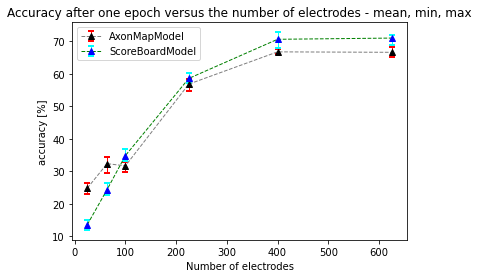

In [286]:
plot_stats(e_radius_acc, 0, label='AxonMapModel', title='Accuracy after one epoch versus the number of electrodes - mean, min, max')
plot_stats(e_radius_acc, 1, label='ScoreBoardModel', line_color='green', marker_color='blue', error_line_color='cyan')
plt.savefig('1_epoch_accuracy_versus_number_of_electrods', bbox_inches='tight')

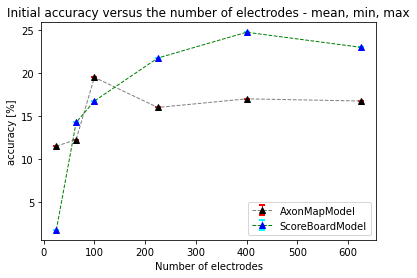

In [293]:
plot_stats(e_radius_acc_init, 0, label='AxonMapModel', title='Initial accuracy versus the number of electrodes - mean, min, max')
plot_stats(e_radius_acc_init, 1, label='ScoreBoardModel', line_color='green', marker_color='blue', error_line_color='cyan')
plt.savefig('init_accuracy_versus_number_of_electrods', bbox_inches='tight')

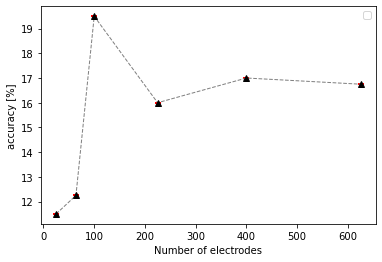

In [271]:
plot_stats(e_radius_acc_init, 0)

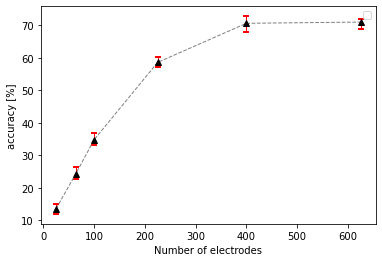

In [272]:
plot_stats(e_radius_acc, 1)

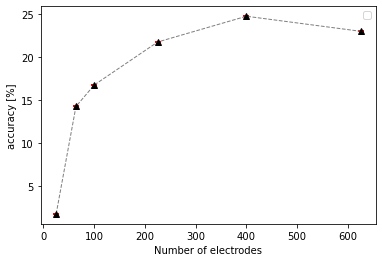

In [273]:
plot_stats(e_radius_acc_init, 1)

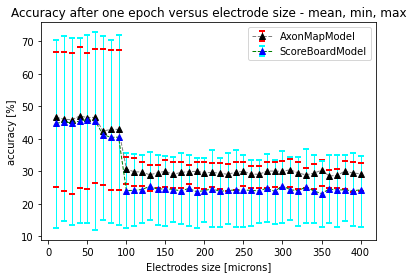

In [290]:
plot_stats(e_num_sides_acc, 0, label='AxonMapModel', title='Accuracy after one epoch versus electrode size - mean, min, max')
plot_stats(e_num_sides_acc, 1, label='ScoreBoardModel', line_color='green', marker_color='blue', error_line_color='cyan')
plt.savefig('1_epoch_accuracy_versus_electrode_size', bbox_inches='tight')

<ipython-input-275-10e7cc20abcc>:2: RuntimeWarning: invalid value encountered in greater
  plt.plot(np.array(e_num_sides)[e_radius_acc[i, :, 1] > 0],
<ipython-input-275-10e7cc20abcc>:3: RuntimeWarning: invalid value encountered in greater
  e_radius_acc[i, e_radius_acc[i, :, 1] > 0, 0])
<ipython-input-275-10e7cc20abcc>:2: RuntimeWarning: invalid value encountered in greater
  plt.plot(np.array(e_num_sides)[e_radius_acc[i, :, 1] > 0],
<ipython-input-275-10e7cc20abcc>:3: RuntimeWarning: invalid value encountered in greater
  e_radius_acc[i, e_radius_acc[i, :, 1] > 0, 0])
<ipython-input-275-10e7cc20abcc>:2: RuntimeWarning: invalid value encountered in greater
  plt.plot(np.array(e_num_sides)[e_radius_acc[i, :, 1] > 0],
<ipython-input-275-10e7cc20abcc>:3: RuntimeWarning: invalid value encountered in greater
  e_radius_acc[i, e_radius_acc[i, :, 1] > 0, 0])
<ipython-input-275-10e7cc20abcc>:2: RuntimeWarning: invalid value encountered in greater
  plt.plot(np.array(e_num_sides)[e_radius_acc[i

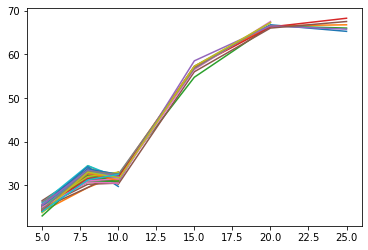

In [275]:
for i in range(e_radius_acc.shape[0]):
    plt.plot(np.array(e_num_sides)[e_radius_acc[i, :, 1] > 0],
             e_radius_acc[i, e_radius_acc[i, :, 1] > 0, 0])

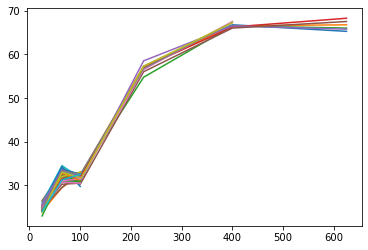

In [40]:
for i in range(e_radius_acc.shape[0]):
    plt.plot((np.array(e_num_sides)**2)[e_radius_acc[i, :, 0] > 0],
             e_radius_acc[i, e_radius_acc[i, :, 0] > 0, 0])

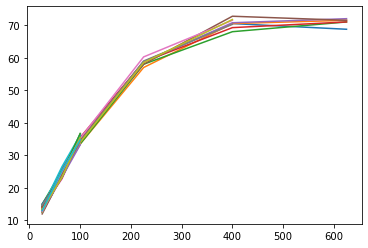

In [44]:
for i in range(e_radius_acc.shape[0]):
    plt.plot((np.array(e_num_sides)**2)[e_radius_acc[i, :, 1] > 0],
             e_radius_acc[i, e_radius_acc[i, :, 1] > 0, 1])

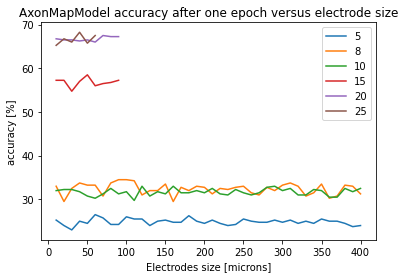

In [292]:
for i in range(e_num_sides_acc.shape[0]):
    plt.plot(np.arange(10, 10 * sum(e_num_sides_acc[i, :, 0] > 0) + 1, 10),
             e_num_sides_acc[i, e_num_sides_acc[i, :, 0] > 0, 0],
             label=e_num_sides[i])
plt.legend()
plt.ylabel('accuracy [%]')
plt.xlabel('Electrodes size [microns]')
plt.title('AxonMapModel accuracy after one epoch versus electrode size')
plt.savefig('1_epoch_accuracy_versus_electrod_size_AxonMap', bbox_inches='tight')

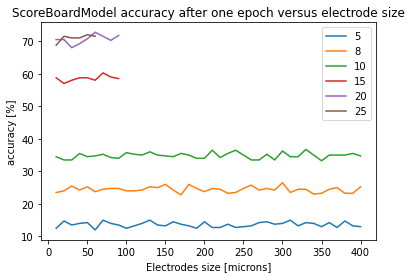

In [291]:
for i in range(e_num_sides_acc.shape[0]):
    plt.plot(np.arange(10, 10 * sum(e_num_sides_acc[i, :, 1] > 0) + 1, 10),
             e_num_sides_acc[i, e_num_sides_acc[i, :, 1] > 0, 1],
             label=e_num_sides[i])
plt.legend()
plt.ylabel('accuracy [%]')
plt.xlabel('Electrodes size [microns]')
plt.title('ScoreBoardModel accuracy after one epoch versus electrode size')
plt.savefig('1_epoch_accuracy_versus_electrod_size_ScoreBoard', bbox_inches='tight')

Print samples from dataset

 Trainset mean value for each channel is: 0.14
 Trainset std  value for each channel is: 0.20


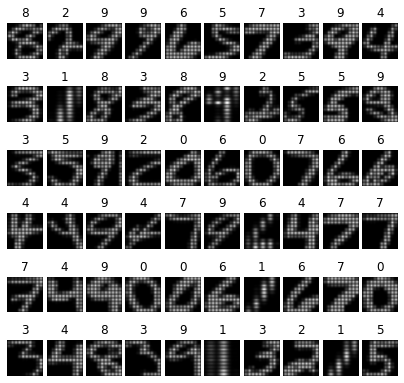

In [7]:
def min_max_scaling(img):
    return (img-img.min())/(img.max()-img.min())

implant_name = 'e_num_side=10-e_radius=30-spacing=None-total_area=4000'

trainloader, testloader = get_dataset_loaders(os.path.join(MNIST_SUBSET_DATA_PATH,
                                                           'ScoreBoardModel'+'-'+implant_name))
dataiter = iter(trainloader)
images, labels = dataiter.next()

num_of_images = 60
fig = plt.figure(figsize=(7, 7))
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(min_max_scaling(np.transpose(images[index], (1, 2, 0))[:, :, 0]), cmap='gray')
    plt.title(int(labels[index].cpu()))
    plt.subplots_adjust(hspace=0, wspace=0.1)

# plt.savefig('ScoreBoardModel_e_num_side=5-e_radius=400_samples', bbox_inches='tight')

Just train one

In [349]:
model_name = 'AxonMapModel'
implant_name = 'e_num_side=10-e_radius=10-spacing=None-total_area=4000'

print(f'# ------------------ {model_name} ----------------- #')

model = ResNet18MNIST(pretrained=True,
                      feature_extraction=True,
                      load_state_path='./data/MNIST__ResNet18Model__Adabound__25_epochs.pth')

criterion = torch.nn.CrossEntropyLoss()
optimizer = AdaBound(model.parameters(), lr=1e-3, final_lr=0.1)
trainloader, testloader = get_dataset_loaders(os.path.join(MNIST_SUBSET_DATA_PATH,
                                                           model_name+'-'+implant_name))
ppln = Pipeline(model, device, optimizer, criterion,
                trainloader, testloader, testloader,
                live_plot=False)

init_loss, init_accu = ppln.test()

_ = ppln.training(epochs=1)

# ------------------ AxonMapModel ----------------- #
 Trainset mean value for each channel is: 0.19
 Trainset std  value for each channel is: 0.23




Training complete in 0m 9s
2 epochs done. Best validation accuracy is 33.000. Best validation loss is 2.780
